# 置信度网络的训练

In [1]:
import numpy as np
import extention_lib
import extention_lib.data_process # 定义了数据处理，计算相关函数
import extention_lib.model        # 定义了置信度网络的模型

## 数据说明(可参考下面的deal_data函数看)
- da[0][0]:置信度，即真实标签

- da[0][1,2]:真实直线的k和b

- da[0][3,4]:拟合直线的k和b

- da[0][5]:用于拟合的第 1 个锚点，是一个list [横坐标 **x**, 纵坐标 **y**, 锚点概率]

- da[0][6]:用于拟合的第 2 个锚点，同上

- da[0][7]:用于拟合的第 3 个锚点，同上

- da[0][8]:用于拟合的第 4 个锚点，同上

。。。。。。

如图所示为6锚点时的情况

<div align="center"><img src=".//img//1.png"  alt="ImageFile"  /></div>

In [2]:
from extention_lib.data_process import GetClockAngle, get_distance_point2line, nodedistance
# 重写deal_data, 方便修改邻接矩阵
def deal_data(da):
    label, data, adj = [], [], []
    for i in range(len(da)):
        
        # 制作 label
        if da[i][0] > 0.55:
            label.append([1, 1, 1, 1, 1])
        elif da[i][0] <= 0.55:
            label.append([0, 0, 0, 0, 0])
        
        # 制作 data
        x_line = [ii[0] for ii in da[i][5:]]
        y_line = [ii[1] for ii in da[i][5:]]
        xy_line = np.array([x_line, y_line])
        P = [ii[2] * 100 for ii in da[i][5:]] # 锚点概率集合
        center = np.mean(xy_line, axis=1)
        k = da[i][3]
        b = center[1] - k * center[0]
        v0 = [10, k * (center[0] + 10) + b - center[1]]

        dat = []
        dat.append([0, 0, 0, 100, k])
        dat.append([50, 0, 0, 100, k])
        dat.append([50, 180, 0, 100, k])
        dat.append([50, 90, 50, 100, k])
        dat.append([50, -90, 50, 100, k])
        for j in range(len(P)): # len(P)表示锚点数量
            v1 = [x_line[j] - center[0], y_line[j] - center[1]]
            angle = GetClockAngle(v0, v1)
            dis = get_distance_point2line([x_line[j], y_line[j]], [k, b])
            dat.append([nodedistance(np.array([x_line[j], y_line[j]]), center), angle, dis, P[j], k])
    
        for j in range(len(P) + 5, 19):# 对于锚点数不足14的数据，补 0 做 padding 
            dat.append([0, 0, 0, 0, 0])
        # dat = torch.tensor(dat, dtype=torch.float)
        data.append(dat)
        
        # 制作邻接矩阵
        ad = []
        
######################################################################################################################################################                                                               """
#####################################################         以下内容需要分类讨论            ##########################################################
        # （1） 四个虚拟锚点到中心节点双向连接，虚拟锚点之间无连接
        for m in range(len(P) + 5):
            if m == 0:
                ad.append([0, 1, 1, 1, 1] + [0 for n in range(14)])
            elif (m >= 1 and m <= 4):
                ad.append([1] + [0 for n in range(18)])
            else:
                ad.append([1, 1, 1, 1, 1] + [0 for n in range(14)])
                
        # （2）四个虚拟锚点和中心节点无区分，全连接
        # for m in range(len(P) + 5):
        #     if (m >= 0 and m <= 4): # 五个虚拟锚点的边
        #         ad.append([1, 1, 1, 1, 1] + [0 for n in range(14)])
        #     else: # 真实锚点的边
        #         ad.append([1, 1, 1, 1, 1] + [0 for n in range(14)])
        
        # （3） 四个虚拟锚点和中心节点双向连接，但多了自己到自己的边
        # m = 0
        # while m in range(len(P) + 5):
        #     if m == 0:
        #         ad.append([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        #         ad.append([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        #         ad.append([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        #         ad.append([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        #         ad.append([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        #         m = 5
        #     else: # 真实锚点的边
        #         ad.append([1, 1, 1, 1, 1] + [0 for n in range(14)])
        #         m += 1
        # （4） 五个虚拟锚点之间自连接
        # m = 0
        # while m in range(len(P) + 5):
        #     if m == 0:
        #         ad.append([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        #         ad.append([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        #         ad.append([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        #         ad.append([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        #         ad.append([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        #         m = 5
        #     else: # 真实锚点的边
        #         ad.append([1, 1, 1, 1, 1] + [0 for n in range(14)])
        #         m += 1
######################################################################################################################################################

        for j in range(len(P) + 5, 19):
            ad.append([0 for n in range(19)])
        adj.append(ad)
    # label = torch.tensor(label, dtype=torch.long)
    return label, data, adj

## 加载数据

In [3]:
l, d, a = [], [], []
id = [4, 6, 8, 10, 12, 14]
for i in range(len(id)):
    for j in range(1, 41):
        if j == 33 or j == 34 or j == 35:
            pass
        else:
            path = 'D:\\GCN\\定位校准\\dingwei_data\\data5\\' + str(id[i]) + '\\' + str(j) + '_' + str(id[i]) + '.npy' # 该数据通过line_test.py生成
            # path = 'D:\\GCN\\定位校准\\dingwei_data\\1_6.npy'
            da = np.load(path, allow_pickle=True)
            label, data, adj = deal_data(da)
            l.append(label)
            d.append(data)
            a.append(adj)

## 处理数据

In [4]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.utils.data as Data

l_all = torch.flatten(torch.tensor(l, dtype=torch.long), start_dim=0, end_dim=1)
d_all = torch.flatten(torch.tensor(d, dtype=torch.float), start_dim=0, end_dim=1)
a_all = torch.flatten(torch.tensor(a, dtype=torch.float), start_dim=0, end_dim=1)
mask = [[True] + [False for i in range(18)]] * (len(l_all))
mask = torch.tensor(mask, dtype=torch.bool)

torch_dataset = Data.TensorDataset(d_all, a_all, l_all, mask)
train_data, test_data = torch.utils.data.random_split(torch_dataset, [int(len(l_all) * 0.8), int(len(l_all) * 0.2)], generator=torch.Generator().manual_seed(42))

train_loader = Data.DataLoader(
    dataset=train_data,  # torch TensorDataset format
    batch_size=1,  # mini batch size
    shuffle=True,  # random shuffle for training
    num_workers=2,  # subprocesses for loading data
)
test_loader = Data.DataLoader(
    dataset=test_data,  # torch TensorDataset format
    batch_size=1,  # mini batch size
    shuffle=False,  # random shuffle for training
    num_workers=2,  # subprocesses for loading data
)

torch_dataset = Data.TensorDataset(d_all, a_all, l_all, mask)

In [8]:
for step, (b_d, b_a, b_l, b_mask) in enumerate(train_loader): 
    print(b_d.shape, b_a.shape, b_l.shape)
    break

torch.Size([1, 19, 5]) torch.Size([1, 19, 19]) torch.Size([1, 5])


## 定义模型训练超参数, 训练模型

In [13]:
from extention_lib.model import GAT

epochs = 100  # 学习轮数
model = GAT(5, 2) # 模型定义

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)  # 优化器
loss_function = torch.nn.CrossEntropyLoss() # 交叉熵损失函数
path = 'E:\\link_quality_estimate\\Initialization_Phase_NDL\\Cross_Modality_localization\\置信度网络\\trained_model\\model_test2.pkl' # 模型保存路径

best_score = float('inf')
best_model = None
epoch_losses = []
for i in range(epochs):
    for step, (b_d, b_a, b_l, b_mask) in enumerate(train_loader): 
        output = model(b_d, b_a)                             
        # loss = loss_function(output[b_mask], b_l)     
        loss = loss_function(output[:,0:5,:].transpose(1, 2), b_l) # [0:5]为前五个虚拟锚点的值，表示对该锚点集合的置信度                
        optimizer.zero_grad()                      
        loss.backward()                              
        optimizer.step()        
    print("【EPOCH: 】%s" % str(i + 1))
    print("训练损失为%s" % (str(loss.item())))
    epoch_losses.append(loss.item())
    if float(loss.item()) < best_score:
        best_score = float(loss.item())
        best_model = model

print(best_score)
torch.save(best_model, path)

【EPOCH: 】1
训练损失为0.34413161873817444
【EPOCH: 】2
训练损失为0.5797098278999329
【EPOCH: 】3
训练损失为0.1394287645816803
【EPOCH: 】4
训练损失为0.00023917625367175788
【EPOCH: 】5
训练损失为0.0009649120038375258
【EPOCH: 】6
训练损失为0.001142062246799469
【EPOCH: 】7
训练损失为0.038053248077631
【EPOCH: 】8
训练损失为0.008157332427799702
【EPOCH: 】9
训练损失为0.30519965291023254
【EPOCH: 】10
训练损失为1.9876559972763062
【EPOCH: 】11
训练损失为0.033254414796829224
【EPOCH: 】12
训练损失为0.031312696635723114
【EPOCH: 】13
训练损失为0.004367183893918991
【EPOCH: 】14
训练损失为4.630460262298584
【EPOCH: 】15
训练损失为0.0108951386064291
【EPOCH: 】16
训练损失为0.06517405062913895
【EPOCH: 】17
训练损失为0.2332485020160675
【EPOCH: 】18
训练损失为1.118139624595642
【EPOCH: 】19
训练损失为0.015036706812679768
【EPOCH: 】20
训练损失为0.5113793611526489
【EPOCH: 】21
训练损失为0.0077489218674600124
【EPOCH: 】22
训练损失为0.35722628235816956
【EPOCH: 】23
训练损失为0.043278150260448456
【EPOCH: 】24
训练损失为0.0018630269914865494
【EPOCH: 】25
训练损失为0.013355305418372154
【EPOCH: 】26
训练损失为0.010319216176867485
【EPOCH: 】27
训练损失为0.02904221974313259
【EPO

NameError: name 'imgPath' is not defined

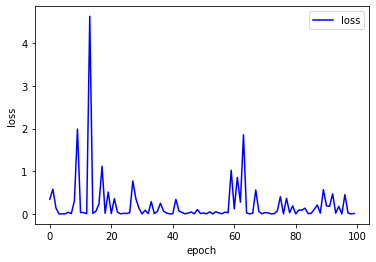

In [8]:
for step, (b_d, b_a, b_l, b_mask) in enumerate(train_loader): 
    output = model(b_d, b_a)
    print(output[:,0:5,:].transpose(1, 2), output[:,0:5,:].transpose(1, 2).shape)
    break    

tensor([[[7.2446, 7.2169, 4.5524, 4.5176, 6.3887],
         [5.5283, 5.3687, 4.0722, 4.0037, 4.8236]]],
       grad_fn=<TransposeBackward0>) torch.Size([1, 2, 5])
